https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [68]:
from PIL import Image

im = Image.open("/home/ljj0512/private/dataset/faces/person-7.jpg")
print(type(im))


<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [24]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode on <- i don't know exactly what it is 

In [28]:
## just import the meta information

landmarks_frame = pd.read_csv('/home/ljj0512/private/dataset/faces/face_landmarks.csv')
print(type(landmarks_frame))
print(landmarks_frame.shape)
# print(landmarks_frame)
print()

n = 65
img_name = landmarks_frame.iloc[n, 0] # row: 65, column: 0
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
print(landmarks.shape)
landmarks = landmarks.astype('float').reshape(-1, 2)
print(landmarks.shape)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks\n{}'.format(landmarks[:4]))
print('First 4 Landmarks\n{}'.format(landmarks[[0,1,2,3]]))

<class 'pandas.core.frame.DataFrame'>
(69, 137)

(136,)
(68, 2)
Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks
[[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]
First 4 Landmarks
[[33. 76.]
 [34. 86.]
 [34. 97.]]


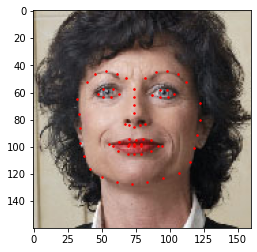

In [26]:
## just show the img file

def show_landmarks(image, landmarks):
    """ Show image with landmarks """
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated


show_landmarks(io.imread(os.path.join('/home/ljj0512/private/dataset/faces/', img_name)),
               landmarks)
plt.show()

In [83]:
## create the custom dataset

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    # __len__ so that len(dataset) returns the size of the dataset.
    def __len__(self):
        return len(self.landmarks_frame)

    # __getitem__ to support the indexing such that dataset[i] can be used to get iith sample.
    def __getitem__(self, idx):
        if torch.is_tensor(idx): # Returns True if obj is a PyTorch tensor.
            idx = idx.tolist() # turn the torch.tensor to list

        img_name = os.path.join(self.root_dir,  
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        # image = torch.from_numpy(image) # turn numpy to torch tensorx
        # image = torch.permute(image, (2,0,1)) # C x H x W
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)

        sample = {'image': image, 'landmarks': landmarks} # to dict <---------- core 
        # sample = (image, landmarks) # to dict <---------- core 

        if self.transform:
            sample = self.transform(sample)

        return sample



face_dataset = CustomDataset(   csv_file='/home/ljj0512/private/dataset/faces/face_landmarks.csv',
                                root_dir='/home/ljj0512/private/dataset/faces/')

print(type(face_dataset))
print(len(face_dataset))
print(face_dataset['image'])
print(len(face_dataset['image']))
# print(type(face_dataset[0]))
# print(len(face_dataset[0]))
print(face_dataset['image'][0].shape)
print(len(face_dataset['image'][0][0,0,0]))
# print('image:',face_dataset[0][0].shape)
# print('value:',face_dataset[0][0][0,0,0])
print('label:',len(face_dataset['image'][1]))

plt.imshow(face_dataset[65][0])

<class '__main__.CustomDataset'>
69


ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

In [76]:
# transform_train = transforms.Compose([
#     # transforms.Resize(215,215),
#     # transforms.RandomCrop(215, padding=4),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.4914, 0.4824, 0.4467),
#                           std=(0.2471, 0.2436, 0.2616))
# ])
# face_dataset = CustomDataset(   csv_file='/home/ljj0512/private/dataset/faces/face_landmarks.csv',
#                                 root_dir='/home/ljj0512/private/dataset/faces/',
#                                 transform=transform_train)
                                
# # face_dataset.transform = transform_train
# print(type(face_dataset))
# print(len(face_dataset))
# print(type(face_dataset[0]))
# print(len(face_dataset[0]))
# print('image:',face_dataset[0][0].shape)
# print('value:',face_dataset[0][0][0,0,0])
# print('label:',len(face_dataset[0][1]))


In [80]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

TypeError: show_landmarks() argument after ** must be a mapping, not tuple

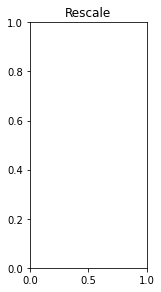

In [81]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [78]:
dataloader = DataLoader(face_dataset, batch_size=4, shuffle=False)
print(dataloader)

for idx, (data, target) in enumerate(dataloader):
    print(idx)
    print(data)
    print(target)
    # if(idx==1):
    #     break
    # print('batch size:',len(data))
    # print('shape of data[0]:',data[0].shape)
    # print('target[0]:',target[0])
    # plt.imshow(data[0].permute(1,2,0))
    # plt.show()

RuntimeError: stack expects each tensor to be equal size, but got [3, 324, 215] at entry 0 and [3, 500, 333] at entry 1